<a href="https://colab.research.google.com/github/ViniciusCastillo/Aprendendo/blob/master/ConcessaoCredito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, plot_confusion_matrix
from scipy import stats
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [4]:
df_cadastro = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/Avaliacao_Credito/main/dados/clientes_cadastrados.csv')
df_credito = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/Avaliacao_Credito/main/dados/clientes_aprovados.csv')

In [5]:
print (df_cadastro.shape)
df_cadastro.head()

(438557, 18)


,ID_Cliente,Genero,Tem_Carro,Tem_Casa_Propria,Qtd_Filhos,Rendimento_Anual,Categoria_de_renda,Grau_Escolaridade,Estado_Civil,Moradia,Idade,Tem_Celular,Tem_telefone_trabalho,Tem_telefone_fixo,Tem_email,Ocupacao,Tamanho_Familia,Anos_empregado
0,5008804,H,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,1,0,0,Outros,2.0,12.4
1,5008805,H,1,1,0,427500.0,Empregado,Ensino superior,Uniao estavel,Alugado,33.0,1,1,0,0,Outros,2.0,12.4
2,5008806,H,1,1,0,112500.0,Empregado,Ensino medio,Casado,Casa propria,59.0,1,0,0,0,Seguranca,2.0,3.1
3,5008808,M,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,1,0,1,1,Venda,1.0,8.4
4,5008809,M,0,1,0,270000.0,Associado comercial,Ensino medio,Solteiro,Casa propria,52.0,1,0,1,1,Venda,1.0,8.4


In [6]:
print (df_credito.shape)
df_credito.head()

(1048575, 3)


,ID_Cliente,Mes_referencia,Faixa_atraso
0,5001711,0,nenhum empréstimo
1,5001711,-1,1-29 dias
2,5001711,-2,1-29 dias
3,5001711,-3,1-29 dias
4,5001712,0,pagamento realizado


In [7]:
faixas = df_credito.Faixa_atraso.unique()
faixas.sort()
faixas

array(['1-29 dias', '120-149 dias', '30-59 dias', '60-89 dias',
       '90-119 dias', '>150 dias', 'nenhum empréstimo',
       'pagamento realizado'], dtype=object)

In [8]:
i = 2
faixas_dict = {}
for item in faixas:
  faixas_dict[item] = i
  if '>' in item: 
    i = 0
  else: 
    i += 1

faixas_dict

{'1-29 dias': 2,
 '120-149 dias': 3,
 '30-59 dias': 4,
 '60-89 dias': 5,
 '90-119 dias': 6,
 '>150 dias': 7,
 'nenhum empréstimo': 0,
 'pagamento realizado': 1}

In [9]:
abertura = df_credito[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').min()
abertura.columns = ['Abertura']
fim = df_credito[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').max()
fim.columns = ['Fim']
janela = abertura.join(fim)
janela['Janela'] = janela['Fim'] - janela['Abertura']
janela.head()

,Abertura,Fim,Janela
ID_Cliente,,,
5001711,-3,0,3
5001712,-18,0,18
5001713,-21,0,21
5001714,-14,0,14
5001715,-59,0,59


In [10]:
# verifica se algum cliente fica algum mês sem dado dentro da janela
contagem = df_credito[['ID_Cliente','Mes_referencia']].groupby('ID_Cliente').count()
contagem.columns = ['Contagem']
contagem = contagem.join(janela)
contagem[contagem['Contagem']-contagem['Janela'] != 1]

,Contagem,Abertura,Fim,Janela
ID_Cliente,,,,


In [11]:
df_credito = df_credito.join(janela, on='ID_Cliente')
df_credito['MOB'] = df_credito['Mes_referencia'] - df_credito['Abertura']
df_credito['Cod_Faixa_Atraso'] = df_credito['Faixa_atraso'].map(faixas_dict)
df_credito.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso
0,5001711,0,nenhum empréstimo,-3,0,3,3,0
1,5001711,-1,1-29 dias,-3,0,3,2,2
2,5001711,-2,1-29 dias,-3,0,3,1,2
3,5001711,-3,1-29 dias,-3,0,3,0,2
4,5001712,0,pagamento realizado,-18,0,18,18,1


In [12]:
df_credito['ref_risco'] = faixas_dict['60-89 dias']
df_credito['Risco'] = 0
df_credito.loc[df_credito['Cod_Faixa_Atraso'] >= df_credito['ref_risco'],'Risco'] = 1
df_credito.drop('ref_risco', axis=1, inplace=True)
df_credito.head()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso,Risco
0,5001711,0,nenhum empréstimo,-3,0,3,3,0,0
1,5001711,-1,1-29 dias,-3,0,3,2,2,0
2,5001711,-2,1-29 dias,-3,0,3,1,2,0
3,5001711,-3,1-29 dias,-3,0,3,0,2,0
4,5001712,0,pagamento realizado,-18,0,18,18,1,0


In [13]:
qtd_clientes = janela.reset_index()[['ID_Cliente','Abertura']].groupby('Abertura').count()
qtd_clientes.columns = ['Qtd_Clientes']
qtd_clientes.head()

,Qtd_Clientes
Abertura,
-60,415
-59,406
-58,440
-57,400
-56,470


In [14]:
primeiro_risco = df_credito.query('Risco == 1')[['MOB','ID_Cliente']].groupby(['ID_Cliente']).min().reset_index()
MOBs = pd.DataFrame(df_credito.MOB.unique())
MOBs.columns = ['MOB']
MOBs_risco = primeiro_risco.merge(MOBs, how="cross", suffixes=('_inicial',''))
MOBs_risco['Risco'] = 0
MOBs_risco.loc[MOBs_risco['MOB'] >= MOBs_risco['MOB_inicial'],'Risco'] = 1
MOBs_risco = MOBs_risco.join(janela, on='ID_Cliente')
MOBs_risco.head()

,ID_Cliente,MOB_inicial,MOB,Risco,Abertura,Fim,Janela
0,5002126,5,3,0,-55,0,55
1,5002126,5,2,0,-55,0,55
2,5002126,5,1,0,-55,0,55
3,5002126,5,0,0,-55,0,55
4,5002126,5,18,1,-55,0,55


In [15]:
vintage = df_credito[['ID_Cliente','Abertura','MOB']].groupby(['Abertura','MOB']).count().reset_index()
vintage = vintage.join(qtd_clientes, on='Abertura')
vintage.drop(['ID_Cliente'], axis=1, inplace=True)
risco = MOBs_risco[['Abertura','MOB','Risco']].groupby(['Abertura','MOB']).sum()
risco.columns=['Qtd_Risco']
vintage = vintage.join(risco, on=['Abertura','MOB'])
vintage['Taxa_Risco'] = vintage['Qtd_Risco']/vintage['Qtd_Clientes']
vintage['Taxa_Risco'].fillna(0)
vintage.Taxa_Risco.max()

0.047325102880658436

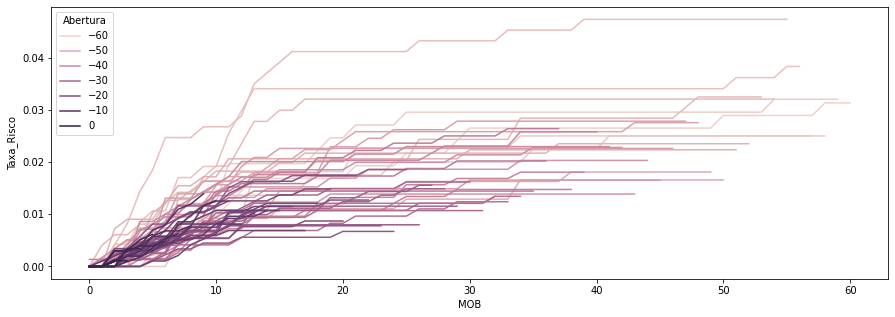

In [45]:
plt.figure(figsize=(15,5))
sb.lineplot(data=vintage, x='MOB', y='Taxa_Risco' , hue='Abertura')

In [48]:
cliente_nasceu_risco = list(primeiro_risco.query('MOB == 0')['ID_Cliente'])
cliente_nasceu_risco

[5024071]

In [49]:
df_credito.query('ID_Cliente == @cliente_nasceu_risco').tail()

,ID_Cliente,Mes_referencia,Faixa_atraso,Abertura,Fim,Janela,MOB,Cod_Faixa_Atraso,Risco
269193,5024071,-34,pagamento realizado,-38,0,38,4,1,0
269194,5024071,-35,pagamento realizado,-38,0,38,3,1,0
269195,5024071,-36,1-29 dias,-38,0,38,2,2,0
269196,5024071,-37,1-29 dias,-38,0,38,1,2,0
269197,5024071,-38,>150 dias,-38,0,38,0,7,1
